## Overview

The problem of *clustering* comes up often in machine learaning, where we want to assign a category or group to a set of data points that are similar.  If we imagine the $xy$ plane, with points scattered around, it might be easy to visually group these points into a number of clusters based on proximity; points that are close to each other are assigned the same cluster.  Similar, in 3D space, points -- or in this case, vectors -- that are close to each other should belong together.

While our eyes can cluster points in 2D or even 3D space with relative ease, what happens when we have a large number of points, say, a few million, or if the "points" we are working with are really $p$-dimensional vectors?  We need an algorithm that can efficiently cluster points for us, regardless of scale or dimension.

The **k-means algorithm** is one solution to the clustering problem: Given $n$ $p$-dimensional vectors, assign each vector to one of $k$ clusters based on Euclidean distance.  Each cluster has a *centroid*, which is simply the mean vector of that cluster.  The procedure is as follows:
  1. Randomly choose $k$ centroids from $n$ vectors.
  2. For each remaining vector $x_i$, compute the distance from $x_i$ to *each* of the centroids.  The cluster corresponding to the centroid closest to $x_i$ is the assigned cluster for $x_i$.
  3. For each cluster, recompute its centroid (we've added and removed vectors in Step 2).
  4. Repeat Steps 2 and 3 until centroids are no longer changing within a desired tolerance level.
  
The k-means algorithm does not guarantee a global optimum as clustering is an [NP-Hard problem](https://en.wikipedia.org/wiki/K-means_clustering).  However, an improved algorithm, **k-means++**, helps k-means converge faster and, in some cases, produces a more optimal clustering, by intelligently choosing the initial centroids.  Loosely speaking, the idea is to randomly choose one initial centroid, and choose the $k-1$ remaining centroids to be as far away from each other as possibe.

---

**Note**: Because this was an academic project, I've hidden my kmeans algorithm code. It is available upon request.

## Visualizing k-means clustering

Let's start by clustering points on a 2-D surface.  We plot variables $x_1$ and $x_2$ and run *k-means* until a tolerance level of 0.01.  This means that we iterate through the algorithm until the distance between corresponding centroids from the previous and current iteration is less than 0.01.

In [4]:
%run kmeans

In [5]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs, load_wine
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from PIL import Image

In [6]:
def plot_clusters(points, centroids, clusters, axis=None, title=None, x_title=None, y_title=None):
    for cluster in clusters:
        coords = points[cluster]
        x = coords[:, 0]
        y = coords[:, 1] if coords.shape[1] == 2 else [0 for _ in range(len(coords))]
        if axis is None:
            plt.scatter(x, y, marker='o', alpha=0.33)
            plt.xlabel(x_title)
            plt.ylabel(y_title)
        else:
            axis.scatter(x, y, marker='o', alpha=0.33)
            axis.set(xlabel=x_title, ylabel=y_title, title=title)
    for cent in centroids:
        x = cent[0]
        y = cent[1] if len(cent) == 2 else 0
        if axis is None:
            plt.scatter(x, y, s=50, c='black', marker='x')
        else:
            axis.scatter(x, y, s=50, c='black', marker='x')

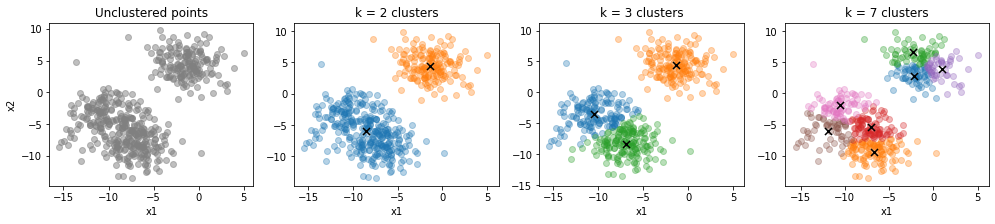

In [8]:
np.random.seed(1)
points, _ = make_blobs(n_samples=500, random_state=1, centers=3, cluster_std=2.2)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(6, 3))
ax1.scatter(points[:, 0], points[:, 1], alpha=0.5, c='grey')
ax1.set(xlabel='x1', ylabel='x2', title='Unclustered points')
plt.subplots_adjust(right=2.3)

for k, ax in zip([2, 3, 7], [ax2, ax3, ax4]):
    centroids, clusters = kmeans(points, k, centroids='kmeans++')
    plot_clusters(points, centroids, clusters, axis=ax, x_title='x1', title=f'k = {k} clusters')

By inspection, the randomized, unclustered points are separated into two distinct clusters.  We see that this is indeed the case when we run *k-means* with $k$ = 2 clusters.  With a tolerance of 0.01, the algorithm easily finds these two clusters (it also helps that we're using *k-means++* to initialize our centroids).  When we increase the number of clusters to 3, we see that the larger cluster on the bottom left is further separated into two clusters.  This is likely due to the fact that it is "elongated" compared to other cluster; naturally, *k-means* would place two centroids in that area.  As we  increase the number of clusters to 7, *k-means* has no choice but to further partition these points into smaller clusters.  We see that the top-right clusters are divided fairly evenly, with roughly 1/3 of the points in each cluster.

---

## Practical applications

The *k-means* algorithm has a wide variety of real-world applications.  For the most part, it's extremely helpful for grouping data points by similarity.

### Binning student exam scores

We can use _k-means_ to cluster points in 1-D space, on a number line.  Below is a toy example of students' exam scores.  Clustering such scores -- especially if the number of samples is large -- could be useful for instructors to quickly bin students by similar scores.

In [9]:
grades = [92.65, 93.87, 74.06, 86.94, 92.26, 94.46, 92.94, 80.65, 92.86, 85.94,
          91.79, 95.23, 85.37, 87.85, 87.71, 93.03, 84.92, 86.02, 75.00, 74.23, 78.98]

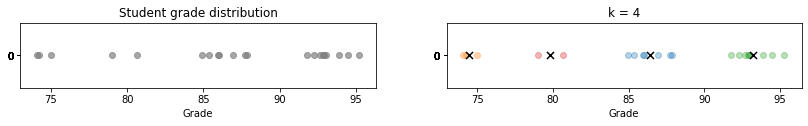

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 1.2))
ax1.scatter(grades, [0 for _ in range(len(grades))], c='grey', alpha=0.7)
ax1.set(xlabel='Grade', title='Student grade distribution')
ax1.set_ylim(-0.05, 0.05)
ax1.set_yticks([0 for _ in range(len(grades))], '')

k = 4
centroids, clusters = kmeans(np.array(grades).reshape(-1, 1), k, centroids='kmeans++')
ax2.set_ylim(-0.05, 0.05)
ax2.set_yticks([0 for _ in range(len(grades))], '')
plot_clusters(np.array(grades).reshape(-1, 1), centroids, clusters, axis=ax2, x_title='Grade', title=f'k = {k}')

### Wine classification

#### Two features

For example, we can try to classify wine types using different sets of features.  Here we use scikit-learn's _wine_ dataset, whose features range from visual aspects such as color intensity, to chemical composition, such as magnesium content.  The target is the wine type, one of {0, 1, 2}.

In [13]:
wine = load_wine()
features = pd.DataFrame(wine.data, columns=wine.feature_names)
target = pd.DataFrame(wine.target, columns=['type'])
wine_df = pd.concat([features, target], axis=1)
wine_df.groupby('type').head(1).reset_index().drop(columns=['index'])

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,type
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,12.37,0.94,1.36,10.6,88.0,1.98,0.57,0.28,0.42,1.95,1.05,1.82,520.0,1
2,12.86,1.35,2.32,18.0,122.0,1.51,1.25,0.21,0.94,4.10,0.76,1.29,630.0,2


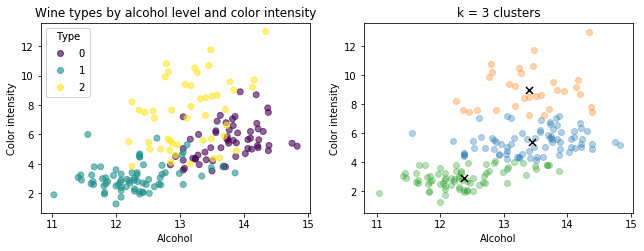

In [8]:
points = wine_df[['alcohol', 'color_intensity']].values
target = wine_df['type'].values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3.5))
plt.subplots_adjust(right=1.3)

sc = ax1.scatter(points[:, 0], points[:, 1], c=target, alpha=0.6)
ax1.set(xlabel='Alcohol', ylabel='Color intensity', title='Wine types by alcohol level and color intensity')
legend1 = ax1.legend(*sc.legend_elements(), loc="best", title="Type")
ax1.add_artist(legend1)

k = 3
centroids, clusters = kmeans(points, k, centroids='kmeans++', tolerance=1e-5)
plot_clusters(points, centroids, clusters, axis=ax2, x_title='Alcohol', y_title='Color intensity', title=f'k = {k} clusters')

plt.show()

The plot on the left shows the actual wine types in with respect to alcohol level and color intensity.  We try to simulate this grouping by applying _k-means_ with 3 clusters.  Overall, we see a relatively accurate result for Type 1; however, _k-means_ is unable to accurately distinguish between Types 0 and 2 due to overlapping points.  It appears that color intensity and alcohol level are not enough to separate wine types spatially, so _k-means_ isn't able to separate those points.  Instead, we see a very clear boundary between the predicted types 0 and 2.

#### All features

Though it's easier to visualize _k-means_ clustering with two features, we can likely achieve better accuracy by using all features in the dataset.  Now, the entire row of the data frame is a point in $p$-dimensional space, where $p$ is 13.

In [9]:
target = wine_df['type'].values
points = wine_df.drop(columns=['type']).values
k = 3
centroids, clusters = kmeans(points, k, centroids='kmeans++', tolerance=1e-6)

In [10]:
wine_df_with_preds = wine_df.copy()
for cluster_indices in clusters:
    prediction = wine_df.loc[cluster_indices, 'type'].mode()[0]
    wine_df_with_preds.loc[cluster_indices, 'pred_type'] = prediction
wine_df_with_preds['pred_type'] = wine_df_with_preds['pred_type'].astype(int)

By treating the mode of the _actual_ wine type as the predicted type for each cluster, we can assess how well _k-means_ was able to classify the wines into their three types:

In [11]:
wine_df_with_preds[['type', 'pred_type']].sample(5)

,type,pred_type
53,0,0
91,1,1
118,1,1
133,2,2
47,0,0


In [12]:
confusion_matrix(wine_df_with_preds['type'], wine_df_with_preds['pred_type'])

array([[46,  0, 13],
       [ 1, 50, 20],
       [ 0, 19, 29]])

In [13]:
f1_score(wine_df_with_preds['type'], wine_df_with_preds['pred_type'], average='weighted')

0.7147804707482469

According to the confusion matrix, wine type 0 was most accurately classified, while type 2 was least accurately classified.  The weighted F1 score is 0.714.

#### Compare to RandomForest

How well, in terms of accuracy and weighted F1 score, does _k-means_ perform compared to more common machine learning algorithms such as RandomForest?

In [14]:
rf = RandomForestClassifier(min_samples_leaf=5, n_estimators=200)
X_train, X_test, y_train, y_test = train_test_split(points, target, test_size=0.3)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

confusion_matrix(y_test, pred)

array([[14,  0,  0],
       [ 0, 26,  1],
       [ 0,  0, 13]])

In [15]:
f1_score(y_test, pred, average='weighted')

0.9816497140047105

It appears that RandomForest is the clear winner, most likely because it picks up on nuances in the dataset that _k-means_ cannot.

### Image compression

One interesting and relevant _k-means_ applications is image compression, in which the total number of colors in an image are reduced to $k$ colors.  Here, the concept of forming clusters around centroids is the same as before, but the actual clusters formed are harder to visualize in that sense.  The method is as follows:
  1. For an $m \times n$ image, where $m$ and $n$ are the height and width of the image, respectively, create an $mn \times 1$ vector.  The vector elements (in a grayscale image these are values from 0 to 255) are then the points to be clustered.
  2. Run _k-means_ on these points, and record the centroid values.
  3. Assign each original color value to the closest centroid such that the entire image now consists of only $k$ colors.
  4. Convert the $mn \times 1$ vector back into a matrix to reconstruct the compressed image.

#### Example: Landscape cartoon

In [325]:
img = Image.open("images/landscape.jpg")
img = img.convert(mode = "L")
points = np.array(img).astype(float)
h, w = points.shape
points = points.reshape(-1, 1)
k = 5
start = time.time()
centroids, clusters = kmeans(points, k=k, centroids='kmeans++', tolerance=0.01)
print(f'Took {round((time.time() - start) / 60, 1)} minutes')

Took 2.6 minutes


In [326]:
def find_min_centroid(x):
    return centroids[np.argmin(np.abs(centroids - x))]

reassigned_points_warriors = np.array([p for p in map(lambda x: find_min_centroid(x), points[:, 0])])

**Original image**:

![Original](landscape_orig.png)

**Clustered image**:

![Clustered](landscape_clustered.png)

<br>

With five colors, we are able to reconstruct the main features of the image, such as mountains, boulders, and people.  However, gradients such as the one around the sun are less distinguishable, since we have a limited range of colors to work with.

---

## Algorithm implementation

I chose to use object-oriented programming, along with `numpy` vector operations, to implement the _k-means_ algorithm.  As OOP seemed to provide a natural structure to the components at play, I created three classes with the following attributes:

  - KMeans: the wrapper object which drives the algorithm and its iterations
  
    * `k`: number of clusters
    * `clusters`: list of `Cluster`s
    * `X`: input matrix of points
    * `tolerance`: tolerance level (default 0.01)
    
  - Cluster: a representation of a cluster of points
  
    * `centroid`: a `Vector`
    * `vectors`: a list of `Vector`s in this cluster
    
  - Vector: a representation of a vector, or point, in space
  
    * `cluster`: the cluster that this vector belongs to
    * `index`: the index of the vector in the original input (for record-keeping)
    * `val`: the vector itself, a `numpy` array

In retrospect, using OOP felt natural but turned out to be _much_ slower than I expected, especially for large input matrices such as high-resolution images.  I realized I wasn't taking full advantage of fast, vectorized `numpy` operations, and my code contained many nested loops.  These were perhaps the biggest contributors to the reduction in speed I was observing.  This clearly points to a tradeoff between readability and clarity _vs_ performance.  In the future, I'd re-implement this primarily with `numpy` arrays and matrices; from an end user's perspective, speed is clearly the goal.